In [14]:
%load_ext autoreload
%autoreload 2
%run ~/FKMC/notebooks/notebook_preamble.py
%matplotlib inline
np.seterr(under = 'ignore')
from time import time
from munch import munchify

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Imported pathlib::Path, os, munch::Munch, pickle, logging, itertools::count, matplotlib::colors
Names are pyplot = plt, matplotlib = mpl, numpy = np


In [15]:
## multi T mutli U data
from FKMC.import_funcs import get_data_funcmap, mean_over_MCMC, IPRandDOS, extract
def load_local(path): 
    p = Path(path).expanduser()
    return get_data_funcmap(p,
                functions = [IPRandDOS(E_bins = np.linspace(-20, 20, 10000 + 1)), 
                             mean_over_MCMC('Mf_moments'),
                            ],
                structure_names = ('repeats',),
                structure_dims = (None,),
               )

logger = logging.getLogger('FKMC.import_funcs')
logger.setLevel(logging.INFO) 

raw_data = dict()

In [19]:
from multiprocessing import Pool
runs = [
    #f"~/HPC_data/local_run_data/run_5_T=1.5",
    f"~/HPC_data/local_run_data/run_8_T=1.5_U=5",
    f"~/HPC_data/local_run_data/run_9_T=2.5_U=5",
]

#doesn't work I think because the returned object is too big
#with Pool(6) as p:
#    raw_data_list = p.map(load_local, runs)

raw_data_list = map(load_local, runs)

for i, path, d in zip(count(), runs, raw_data_list):
    raw_data[i] = munchify(d)
    print(f"path: {path}, structure_dims: {raw_data[i].structure_dims}")

print('done!')

p = Path('~/HPC_data/pickled_data/local_runs_processed.pickle').expanduser()
with open(p, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(raw_data, f, pickle.HIGHEST_PROTOCOL)
    print('Pickling Successful')

looking in /Users/tom/HPC_data/local_run_data/run_8_T=1.5_U=5


0 2 4 6 8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 

looking in /Users/tom/HPC_data/local_run_data/run_9_T=2.5_U=5


path: ~/HPC_data/local_run_data/run_8_T=1.5_U=5, structure_dims: (100,)
0 3 6 9 12 15 18 21 24 27 30 33 36 39 42 45 48 51 54 57 60 63 66 69 72 75 78 81 84 87 90 93 96 99 102 105 108 111 114 117 120 123 126 129 132 135 138 141 144 147 150 153 156 159 162 165 168 path: ~/HPC_data/local_run_data/run_9_T=2.5_U=5, structure_dims: (169,)
done!


Unpickling Successful


In [28]:
from munch import munchify
from FKMC.general import smooth, spread
from scipy.stats import sem


def interpolate_IPR(E_bins, unsmoothed_DOS, IPR, dIPR):
    newshape = (IPR.size // IPR.shape[-1], IPR.shape[-1])
    _DOS = unsmoothed_DOS.reshape(newshape)
    _IPR = IPR.reshape(newshape)
    _dIPR = dIPR.reshape(newshape)
    
    for i, DOS, I, dI in zip(count(), _DOS, _IPR, _dIPR):
        ei = DOS > 0
        if any(ei):
            _I = I[ei]
            _dI = dI[ei]
            xI = E_bins[1:][ei]

            _IPR[i] = np.interp(E_bins[1:], xI, _I)
            _dIPR[i] = np.interp(E_bins[1:], xI, _dI)
        else:
            _IPR[i] = E_bins[1:] * np.NaN
            _dIPR[i] = E_bins[1:] * np.NaN

def prepare_data(o):
    o.energy_histogram_bins = o.E_bins

    interpolate_IPR(o.E_bins, unsmoothed_DOS=o.DOS, IPR=o.IPR, dIPR=o.dIPR)

    mean_axis = (1,) #mean out the repeat and starting states axes
    sem_axis = 1
    
    #use the indepedant repeats to estimate the errors
    o.DOS, o.dDOS = o.DOS.mean(axis = mean_axis), sem(o.DOS, axis = sem_axis)
    o.IPR, o.dIPR = o.IPR.mean(axis = mean_axis), sem(o.IPR, axis = sem_axis)

    print('\nShape of o.DOS after mean')
    print(o.DOS.shape)
    o.hints.DOS = np.delete(o.hints.DOS, mean_axis)
    print(o.hints.DOS)

    #('Ns', 'Ts', 'energy index')

    #smooth them
    for i, N in zip(count(), o.Ns):
        scale = 0.1
        o.DOS[i] = smooth(o.DOS[i], scale)
        o.IPR[i] = smooth(o.IPR[i], scale)

        o.dDOS[i] = smooth(o.dDOS[i], scale)
        o.dIPR[i] = smooth(o.dIPR[i], scale)
    return o
    
p = Path('~/HPC_data/pickled_data/local_runs_processed.pickle').expanduser()
with open(p, 'rb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    raw_data = pickle.load(f)
    print('Unpickling Successful')
    
data = dict()    
for name, o in raw_data.items():
    o = munchify(o)
    print(f'steps per file = {o.MCMC_params.N_steps}, thin = {o.MCMC_params.thin}')
    print(f'Doing {name}, T={1 / o.parameters.beta}, U={o.parameters.U}, J={o.parameters.J}')
    print(f'Ns = {o.Ns}')
    data[name] = prepare_data(o)
    
p = Path('~/HPC_data/pickled_data/local_runs_processed_smoothed_june2.pickle').expanduser()
with open(p, 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
    print('Pickling Successful')    

print('Done')

Unpickling Successful
steps per file = 500, thin = 10
Doing 0, T=1.5, U=5, J=5
Ns = [ 40  60  70  80 100 120 150 180 220 270]

Shape of o.DOS after mean
(10, 10000)
['Ns' 'energy index']
steps per file = 500, thin = 10
Doing 1, T=2.5, U=5, J=5
Ns = [ 40  60  70  80 100 120 150 180 220 270]

Shape of o.DOS after mean
(10, 10000)
['Ns' 'energy index']
Pickling Successful
Done


Ns = [ 40  60  70  80 100 120 150 180 220 270]


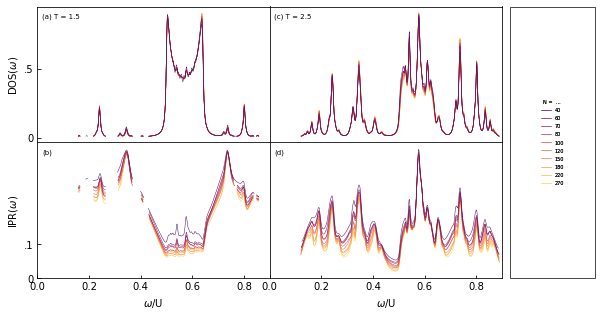

In [29]:
from customcolors import colors, colors10

o1, o2 = data.values()

linewidth = 0.5
xlim = (0, 0.9)
legend_fontsize = 5
legend_wspace = 0.01
legend_labelspacing = 0.63
wspace = 0
hspace = 0

f = plt.figure(constrained_layout=False)
gs = f.add_gridspec(2, 3, width_ratios=[1, 1, 0.4], wspace = wspace, hspace = hspace)

axes = np.array([
    [f.add_subplot(gs[0, 0]), f.add_subplot(gs[1, 0])],
    [f.add_subplot(gs[0, 1]), f.add_subplot(gs[1, 1])],
       ])
legend_axis = f.add_subplot(gs[:, 2], visible = False)

for ax in axes:
    ax[0].tick_params(axis = 'x', bottom = False, labelbottom = False)
    ax[1].tick_params(axis = 'x', top = False, labeltop = False)
    
axes[1,0].tick_params(axis = 'y', left = False, labelleft = False)
axes[1,1].tick_params(axis = 'y', left = False, labelleft = False)
axes[0,0].tick_params(axis = 'y', right = False, labelright = False)
axes[0,1].tick_params(axis = 'y', right = False, labelright = False)

lines = [None for _ in o1.Ns]
o = o1
print(f"Ns = {o.Ns}")
for i,N in list(enumerate(o.Ns))[::-1]:
    for o, col in zip([o1, o2], axes):
        E = np.where(o.DOS[i] > 0.01, o.DOS[i], np.NaN)
        I = np.where(o.DOS[i] > 0.01, o.IPR[i], np.NaN)
        lines[i], = col[0].plot(o.E_bins[1:] / o.parameters.U, E, label = f'N = {N}', color = colors10[i], linewidth = linewidth) 
        col[1].plot(o.E_bins[1:] / o.parameters.U, I, color = colors10[i], linewidth = linewidth)
    
    
for a in axes.flatten(): a.set(xlim = xlim)
    
axes[0,0].set(ylabel = 'DOS($\omega$)', yticks = [0, 0.5], yticklabels = ['0', '.5'])
axes[0,1].set(ylabel = 'IPR($\omega$)', xlabel = '$\omega$/U', yticks = [0, 0.1], yticklabels = ['0', '.1'])
axes[1,1].set(xlabel = '$\omega$/U')

#axes[0].legend()

for a in axes.flatten(): a.tick_params(direction = "in")
  
for label, ax in zip([f"(a) T = {1 / o1.parameters.beta}",
                      "(b)",
                      f"(c) T = {1 / o2.parameters.beta}",
                      "(d)"],
                     axes.flatten()):
    ax.text(0.02, 0.95, label, transform=ax.transAxes,
            fontsize=7, fontweight='normal', va='top', color = 'black')
    
from matplotlib.legend import Legend

#get the x position of the right of the plots in figure coords
_, (x0, _) = axes[1,0].get_position().get_points()
#get the y position of the bottom of the plots in figure coords
(_, y0), _ = axes[1,1].get_position().get_points()
#get the top right of the legend axis
_, (x1, y1) = legend_axis.get_position().get_points()


rect = mpl.patches.Rectangle((x0+legend_wspace,y0),x1-x0-legend_wspace,y1-y0,
                             linewidth=0.7,
                             edgecolor='k',
                             facecolor='none',
                             transform = f.transFigure)
f.add_artist(rect)

leg = f.legend(
             handles = lines, 
             labels = [f"{N}" for N in o.Ns],
             frameon=True,
             fontsize = legend_fontsize,
             loc = 'center',
             bbox_to_anchor=rect.get_bbox(),
            labelspacing = legend_labelspacing,
           fancybox = False,
           bbox_transform=f.transFigure,
)
#modify the frame of the legend
frame = leg.get_frame()
frame.set(visible = False)

#change the title of the legend
leg.set_title("N =  ... ", prop = dict(size = legend_fontsize))

#add the legend to the figure
f.add_artist(leg);

f.subplots_adjust()
f.set_size_inches(10,5)

In [8]:
for name, o in data.items():
    o = munchify(o)
    print(f'steps per file = {o.MCMC_params.N_steps}, thin = {o.MCMC_params.thin}')
    
500 * 800

steps per file = 500, thin = 10
steps per file = 500, thin = 10


400000

In [12]:
p = Path(f'~/HPC_data/pickled_data/local_runs_processed_smoothed_june2.pickle').expanduser()
with open(p, 'rb') as file: 
    data = pickle.load(file)
    print(data.keys())

dict_keys([0, 1])


In [ ]:
single.hints.Mf_moments

In [ ]:
data[1].hints.DOS, data[1].DOS.shape, data[1].E_bins.shape

Text(0.5, 0.98, 'T = 1.5 U = 5')

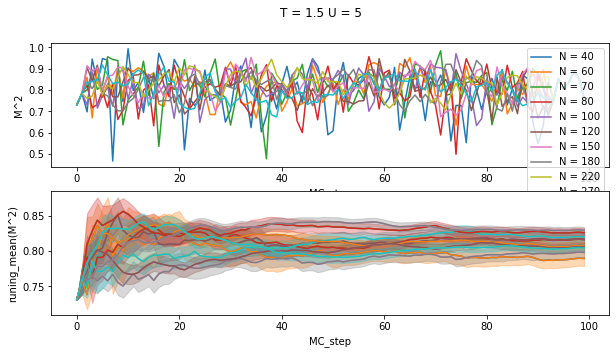

In [13]:
from FKMC.general import running_mean, running_sem
from FKMC.plotting import spread



def plot_Mf_mean(single):
    f, (ax,axcum) = plt.subplots(2,1, figsize = (10,5))
    for i, N in zip(count(), single.Ns):
        ax.plot(single.Mf_moments[i, :, 2], label = f'N = {N}')

        axcum.plot(running_mean(single.Mf_moments[i, :, 2]), label = f'N = {N}')
        Y = running_mean(single.Mf_moments[i, :, 2])
        dY = running_sem(single.Mf_moments[i, :, 2])
        X = np.arange(len(Y))

        spread(axcum, X, Y, dY, alpha = 0.3)

    ax.set(xlabel = "MC_step", ylabel = 'M^2')
    axcum.set(xlabel = "MC_step", ylabel = 'runing_mean(M^2)')
    ax.legend()
    
    return f, (ax, axcum)
  
i = 0
f, axes = plot_Mf_mean(data[i])
f.suptitle(f'T = {1 / data[i].parameters.beta} U = {data[i].parameters.U}')

In [ ]:
i = 1
f, axes = plot_Mf_mean(data[i])
f.suptitle(f'T = {1 / data[i].parameters.beta} U = {data[i].parameters.U}')

In [ ]:
i = 2
f, axes = plot_Mf_mean(data[i])
f.suptitle(f'T = {1 / data[i].parameters.beta} U = {data[i].parameters.U}')

In [ ]:
from FKMC.plotting import plot_scaling_dimension
o = data[1]

f, axes = plot_scaling_dimension(
                       original_data = o,
                       filter_indices = None,
                       spread_IPR = True,
                       cutoffs = [0,],
                       DOS_cutoff = 0.001)

axes[0].legend()
axes[0].set(xlim = (-1, 1))
f.suptitle(f'T = {1 / o.parameters.beta}, J = {o.parameters.J}, U = {o.parameters.U}, M**2 = {o.Mf_moments[-1, :, 2].mean():.2f}')

In [ ]:
from FKMC.plotting import plot_scaling_dimension
o = data[1]

f, axes = plot_scaling_dimension(
                       original_data = o,
                       filter_indices = None,
                       spread_IPR = True,
                       cutoffs = [0,],
                       DOS_cutoff = 0.001)

axes[0].legend()
axes[0].set(xlim = (0.3, 0.7))
f.suptitle(f'T = {1 / o.parameters.beta}, J = {o.parameters.J}, U = {o.parameters.U}, M**2 = {o.Mf_moments[-1, :, 2].mean():.2f}')

In [ ]:
from FKMC.plotting import plot_scaling_dimension
o = data[2]

f, axes = plot_scaling_dimension(
                       original_data = o,
                       filter_indices = None,
                       spread_IPR = True,
                       cutoffs = [0,],
                       DOS_cutoff = 0.001)

axes[0].legend()
axes[0].set(xlim = (-1, 1))
f.suptitle(f'T = {1 / o.parameters.beta}, J = {o.parameters.J}, U = {o.parameters.U}, M**2 = {o.Mf_moments[-1, :, 2].mean():.2f}')

In [ ]:
from FKMC.plotting import plot_scaling_dimension
o = data[2]

f, axes = plot_scaling_dimension(
                       original_data = o,
                       filter_indices = None,
                       spread_IPR = True,
                       cutoffs = [0,],
                       DOS_cutoff = 0.001)

axes[0].legend()
axes[0].set(xlim = (0.3, 0.7))
f.suptitle(f'T = {1 / o.parameters.beta}, J = {o.parameters.J}, U = {o.parameters.U}, M**2 = {o.Mf_moments[-1, :, 2].mean():.2f}')

In [ ]:
from FKMC.plotting import plot_scaling_dimension

o = data[2]

f, axes = plot_scaling_dimension(
                       original_data = o,
                       filter_indices = None,
                       spread_IPR = True,
                       cutoffs = [0,],
                       DOS_cutoff = 0.001,
                       #Nmask = [-1],
                      colors = ['b',] * 10,
)

o = data[1]

plot_scaling_dimension(
                       original_data = o,
                       filter_indices = None,
                       spread_IPR = True,
                       cutoffs = [0,],
                       DOS_cutoff = 0.001,
                       #Nmask = [-1],
                       axes = axes,
                        colors = ['orange',] * 10,
)

o = data[2]

plot_scaling_dimension(
                       original_data = o,
                       filter_indices = None,
                       spread_IPR = True,
                       cutoffs = [0,],
                       DOS_cutoff = 0.001,
                       #Nmask = [-1],
                       axes = axes,
                       colors = ['g',] * 10,
)


from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='b', label='T = 1.5, U =10'),
    Line2D([0], [0], color='orange', label='T = 1.5, U =5'),
    Line2D([0], [0], color='g', label='T = 2.5, U = 5'),
                  ]
axes[0].legend(handles=legend_elements)

axes[0].set(xlim = (-1, 1))
f.suptitle(f'J = {o.parameters.J}, U = {o.parameters.U}')